# Deep Learning – Multilayer Perceptron with PyTorch (Applied Lab)

**Authored by : Alexandre Mathias DONNAT, Sr - Télécom Paris**

This notebook provides a hands-on introduction to the foundations of neural network training with PyTorch, through the implementation and analysis of a multilayer perceptron (MLP) applied to a real-world multi-class classification problem.

Our objective is not only to train a model, but to understand the full learning pipeline, from raw data ingestion to model evaluation, by explicitly implementing each component of the workflow.

We base our experiments on the Dry Bean Dataset, a real-world multi-class dataset commonly used for classification benchmarks. The dataset is publicly available on Kaggle
(https://www.kaggle.com/datasets/muratkokludataset/dry-bean-dataset
)
and can be directly downloaded from the UCI Machine Learning Repository
(https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip
).

The notebook covers the following steps:

- Data acquisition and preprocessing : We download the dataset from public repositories and process it using Pandas. Features and labels are extracted, and the data is split into training and evaluation sets to enable out-of-sample performance assessment.

- Custom dataset and data loading : We implement a custom PyTorch Dataset to provide samples on the fly, and wrap it into a DataLoader to handle batching and shuffling. This illustrates the separation between data representation and data access in PyTorch.

- Neural network modeling with nn.Module : We define a multilayer perceptron using the nn.Module formalism, highlighting the structure of fully connected networks, the role of non-linear activation functions, and the mapping from input features to class probabilities.

- Training and evaluation loop : We implement a complete optimization loop over epochs, including mini-batch training, forward and backward passes, parameter updates, and evaluation on a held-out dataset. Training and evaluation losses and accuracies are tracked at each epoch.

- Learning dynamics and empirical analysis : We visualize the evolution of losses and accuracies over epochs to analyze convergence behavior, generalization performance, and potential overfitting in a supervised learning setting.


# Import packages

In [ ]:
import os
import zipfile
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import openpyxl

# Data acquisition

Get the Dry Bean Dataset

Documentation: https://www.kaggle.com/datasets/muratkokludataset/dry-bean-dataset

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip

In [12]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"
zip_path = "DryBeanDataset.zip"
data_dir = "DryBeanDataset"

if not os.path.exists(data_dir):
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")

# Data preprocessing (using pandas and sklearn)

Process the data
* load the .xls file data using `pandas` (read_excel)
* split into X (all columns except `Class`) and y (column `Class`) using `pandas`
* convert y to integer using `sklearn` (LabelEncoder)
* split into train and valid datasets using `sklearn` (train_test_split), we use a 80\% train, 20\% validation split
* standardize the X of train and valid using `sklearn` (StandardScaler)



In [ ]:
def load_and_preprocess(data_file, test_size=0.2, random_state=42):
    # Load
    df = pd.read_excel(data_file)

    # Split X / y
    X = df.drop(columns=["Class"]).values.astype(np.float32)
    y = df["Class"].values

    # Encode labels -> integers 0..K-1
    le = LabelEncoder()
    y = le.fit_transform(y).astype(np.int64)

    # Train/valid split (stratified)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Standardize using train stats only
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_valid = scaler.transform(X_valid).astype(np.float32)

    num_classes = len(np.unique(y))

    return X_train, X_valid, y_train, y_valid, num_classes

data_file = "DryBeanDataset/Dry_Bean_Dataset.xlsx"
X_train, X_valid, y_train, y_valid, num_classes = load_and_preprocess(data_file)
print(X_train.shape, X_valid.shape, num_classes)

(10888, 16) (2723, 16) 7


In [9]:
print(X_train.shape)
print(y_train.shape)
print(set(y_train))

print(X_valid.shape)
print(y_valid.shape)
print(set(y_valid))

(10888, 16)
(10888,)
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}
(2723, 16)
(2723,)
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


# Write the pytorch Dataset and Dataloader

create a pytorch Dataset to allow getting X and y on the fly
* we need to convert the data from numpy to torch-tensors

In [15]:
class BeanDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, 16) float32
        # y: (N,) int64
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = BeanDataset(X_train, y_train)
valid_dataset = BeanDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Write the MLP model using `nn.Module`

The MLP model as the following architecture: `input_dim -> 128 -> 64 -> 64 -> output_dim`
* `output_dim`corresponds to the number of classes
* we put a `ReLU` between each layer
* while we should put a `softmax` activation at the end (since we deal with a multi-class problem) in pytorch it is usual to combine the `softmax` with the `categorical-cross-entropy` using a loss named `CrossEntropyLoss`. We therefore ignore the output activation in the model.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # logits
        )

    def forward(self, x):
        hat_y = self.net(x)
        return hat_y


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X_train.shape[1], num_classes).to(device)
print(device, model)

cpu MLP(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
)


The output displays the structure of the MLP model running on the CPU. The network is built using `nn.Sequential` and consists of a series of fully connected (`Linear`) layers with `ReLU` activations in between. The input features (16) are progressively transformed through hidden layers of sizes 128, 64, and 64.
The final layer outputs 7 values (logits), corresponding to the 7 classes in the dataset. No activation function is applied at the output, as `CrossEntropyLoss` internally applies the softmax during training.

This architecture defines a standard MLP for multi-class classification on tabular data.

# Define the loss to be minimized and the optimizer

As said above, we use a loss named `CrossEntropyLoss` which combines the `softmax`and `categorical-cross-entropy`.

We optimize the model using an `Adam` optimizer using a learning rate of 0.001.

In [18]:
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Write the main loop

We write the main loop over epochs.
For each epoch
* we train the model
    * we set the model in train mode using `model.train()`
    * we loop over mini-batches of training data: zero_grad(), forward, loss, backward, step
    * we compute the current accuracy
* we evaluate the currently trained model on the validation data
    * we set the model in train mode using `model.eval()`
    * we loop over mini-batches of validation data: forward, loss
    * we compute the current loss and accuracy
* we store and print the loss and accuracy for training and validation data

In [ ]:
epochs = 100
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": []
}

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss /= total
    train_acc = correct / total

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            valid_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    valid_loss /= total
    valid_acc = correct / total

    # Logging
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f} | "
            f"Valid Loss {valid_loss:.4f} | Valid Acc {valid_acc:.2f}"
        )

Epoch 005 | Train Loss 0.1962 | Train Acc 0.93 | Valid Loss 0.2403 | Valid Acc 0.91
Epoch 010 | Train Loss 0.1881 | Train Acc 0.93 | Valid Loss 0.2099 | Valid Acc 0.92
Epoch 015 | Train Loss 0.1819 | Train Acc 0.93 | Valid Loss 0.2057 | Valid Acc 0.92
Epoch 020 | Train Loss 0.1768 | Train Acc 0.93 | Valid Loss 0.2124 | Valid Acc 0.92
Epoch 025 | Train Loss 0.1708 | Train Acc 0.94 | Valid Loss 0.2061 | Valid Acc 0.92
Epoch 030 | Train Loss 0.1664 | Train Acc 0.94 | Valid Loss 0.2016 | Valid Acc 0.93
Epoch 035 | Train Loss 0.1648 | Train Acc 0.94 | Valid Loss 0.2031 | Valid Acc 0.93
Epoch 040 | Train Loss 0.1601 | Train Acc 0.94 | Valid Loss 0.2010 | Valid Acc 0.93
Epoch 045 | Train Loss 0.1598 | Train Acc 0.94 | Valid Loss 0.1969 | Valid Acc 0.93
Epoch 050 | Train Loss 0.1541 | Train Acc 0.94 | Valid Loss 0.2132 | Valid Acc 0.92
Epoch 055 | Train Loss 0.1502 | Train Acc 0.94 | Valid Loss 0.1995 | Valid Acc 0.93
Epoch 060 | Train Loss 0.1458 | Train Acc 0.94 | Valid Loss 0.2020 | Valid A

# Plot the loss and accuracy evolution over epoches for train and test data

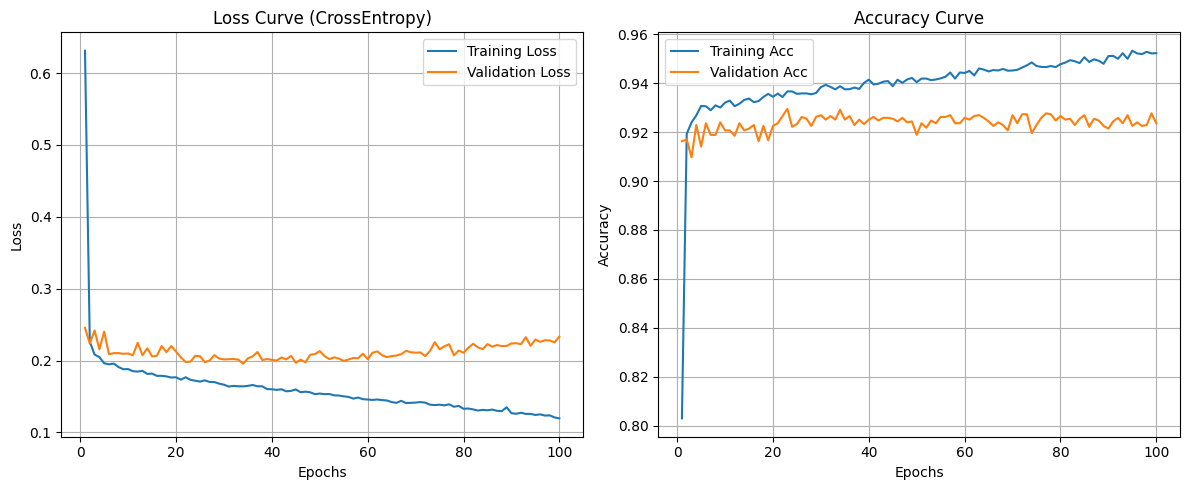

In [ ]:
epochs = len(history["train_loss"])
x = np.arange(1, epochs + 1)

plt.figure(figsize=(12, 5))

# curve 
plt.subplot(1, 2, 1)
plt.plot(x, history["train_loss"], label="Training Loss")
plt.plot(x, history["valid_loss"], label="Validation Loss")
plt.title("Loss Curve (CrossEntropy)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(x, history["train_acc"], label="Training Acc")
plt.plot(x, history["valid_acc"], label="Validation Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The training loss decreases steadily over epochs, indicating that the model successfully learns from the training data. The validation loss drops rapidly at the beginning and then stabilizes slightly above the training loss, suggesting good generalization with limited overfitting.

The training accuracy increases progressively and reaches around 95%, while the validation accuracy quickly converges to approximately 92–93% and remains stable. The small gap between training and validation accuracy at later epochs indicates mild overfitting, which is expected when training for a large number of epochs.
the MLP converges correctly and achieves strong and stable performance on the validation dataset.


# Early-stopping

In the above, we start doing over-fitting (the loss still decreases for the training data but starts increasing for the validation data). We should stop before this. This is named **early-stopping**. Write a test in the training loop which stop the training when the validation-loss starts increasing.

In [ ]:
# Reinitialize model + optimizer before early stopping
model = MLP(X_train.shape[1], num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": []
}

# Early stopping hyperparams
patience = 5
best_valid_loss = float("inf")
epochs_no_improve = 0

for epoch in range(epochs):
    # Train
    model.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    valid_loss_sum = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            valid_loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            valid_correct += (preds == yb).sum().item()
            valid_total += yb.size(0)

    valid_loss = valid_loss_sum / valid_total
    valid_acc = valid_correct / valid_total

    # Logging
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.3f} | "
            f"Valid Loss {valid_loss:.4f} | Valid Acc {valid_acc:.3f}"
        )

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(
            f"Early stopping triggered at epoch {epoch+1} "
            f"(best valid loss: {best_valid_loss:.4f})"
        )
        break

Epoch 005 | Train Loss 0.1962 | Train Acc 0.929 | Valid Loss 0.2262 | Valid Acc 0.917
Epoch 010 | Train Loss 0.1850 | Train Acc 0.930 | Valid Loss 0.2075 | Valid Acc 0.926
Epoch 015 | Train Loss 0.1811 | Train Acc 0.933 | Valid Loss 0.2114 | Valid Acc 0.920
Early stopping triggered at epoch 16 (best valid loss: 0.2000)


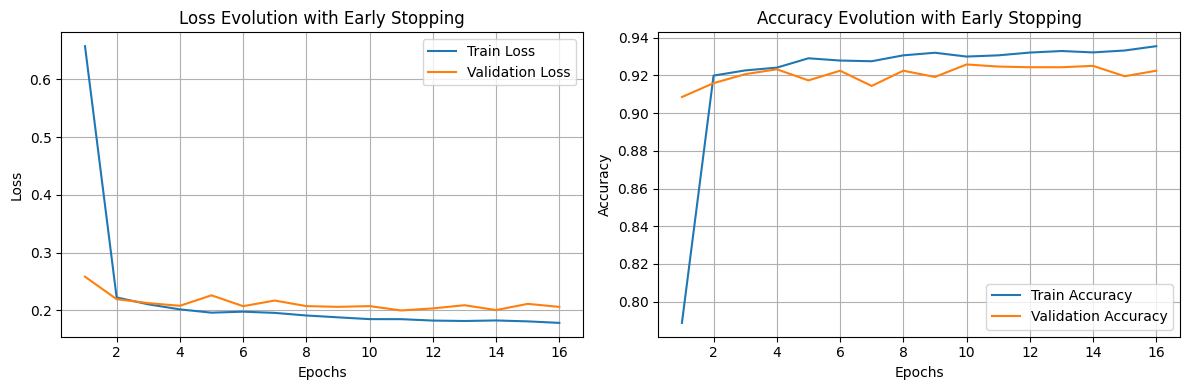

In [25]:
epochs_run = len(history["train_loss"])
x = np.arange(1, epochs_run + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(x, history["train_loss"], label="Train Loss")
plt.plot(x, history["valid_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Evolution with Early Stopping")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(x, history["train_acc"], label="Train Accuracy")
plt.plot(x, history["valid_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Evolution with Early Stopping")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

When training the model with early stopping, the validation loss is monitored at each epoch and training is stopped when no further improvement is observed for several consecutive epochs (patience = 5). This prevents unnecessary training once the model stops generalizing better to unseen data.

The loss curves show a rapid decrease during the first epochs, followed by a stabilization of the validation loss, indicating convergence. The training loss continues to decrease slightly, while the validation loss oscillates around a minimum value, which triggers early stopping.

The accuracy curves confirm this behavior: training accuracy increases smoothly, while validation accuracy reaches a stable plateau around 92–93%. The small gap between training and validation accuracy suggests limited overfitting and good generalization.
Early stopping allows the model to stop at an appropriate epoch while maintaining strong validation performance.
